# Projeto 14: Deep Dream

Codificação adaptada da documentação do TensorFlow: https://www.tensorflow.org/beta/tutorials/generative/deepdream
 

# Etapa 1: Importação das bibliotecas

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
tf.__version__

TensorFlow 2.x selected.


'2.1.0-rc1'

# Etapa 2: Importação do modelo com pesos pré-treinados

In [0]:
base_model = tf.keras.applications.InceptionV3(include_top = False,
                                              weights = 'imagenet')

In [4]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Nota:
- O objetivo do algoritmo é selecionar uma camada para maximizar a loss function, que são as ativações
- Podemos selecionar qualquer camada, lembrando que as primeiras camadas possuem características mais simples (bordas) e camadas superiores possuem características mais complexas e detalhadas dos objetos
- A rede Inception possui múltiplas camadas concatenadas chamadas de 'mixed' 

In [0]:
# names = ['mixed8', 'mixed9']
#names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']
names = ['mixed3', 'mixed5']
# names = ['mixed5']

In [0]:
layers = [base_model.get_layer(name).output for name in names]

In [17]:
layers

[<tf.Tensor 'mixed3/Identity:0' shape=(None, None, None, 768) dtype=float32>,
 <tf.Tensor 'mixed5/Identity:0' shape=(None, None, None, 768) dtype=float32>]

In [0]:
deepdream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

# Etapa 3: Processar uma imagem

In [0]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/StaryNight.jpg',
                                                     target_size = (225, 375))

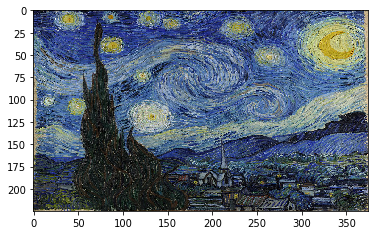

In [42]:
plt.imshow(sample_image)

In [43]:
type(sample_image)

PIL.Image.Image

In [44]:
sample_image = np.array(sample_image) / 255.0
sample_image.shape

(225, 375, 3)

In [45]:
type(sample_image)

numpy.ndarray

In [46]:
sample_image.max()

1.0

In [47]:
sample_image.min()

0.0

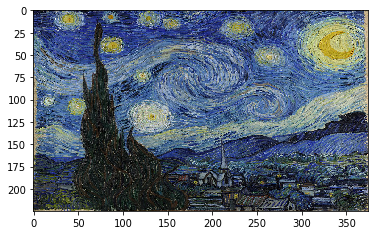

In [48]:
plt.imshow(sample_image)

# Etapa 4: Executar o modelo pré-treinado e explorar as ativações

In [49]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image.shape

(225, 375, 3)

In [50]:
type(sample_image)

numpy.ndarray

In [0]:
sample_image = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(sample_image))

In [20]:
type(sample_image)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [52]:
sample_image = tf.expand_dims(sample_image, axis = 0)
np.shape(sample_image)

TensorShape([1, 225, 375, 3])

In [53]:
sample_image.shape

TensorShape([1, 225, 375, 3])

In [0]:
activations = deepdream_model(sample_image)

In [55]:
len(activations)

2

In [56]:
activations[1]

<tf.Tensor: shape=(1, 12, 21, 768), dtype=float32, numpy=
array([[[[3.3623037 , 4.190623  , 3.9559448 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 3.291566  , ..., 0.        ,
          0.        , 0.        ],
         [1.193265  , 2.8545077 , 0.96760666, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.04281037, 1.3122522 , 1.0145415 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 2.0416923 , ..., 0.        ,
          0.        , 0.04361733],
         [1.5414263 , 1.8796766 , 1.8178892 , ..., 0.        ,
          0.        , 0.19873492]],

        [[1.1934961 , 2.1502764 , 2.3389978 , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 4.6458354 , ..., 0.        ,
          0.        , 0.        ],
         [0.21733464, 1.6891705 , 0.23644185, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.452390

# Etapa 5: Cálculo da loss

- Calcularemos a loss que representa o somatório das ativações de uma camada específica
- Na maioria das vezes o objetivo é minizar o erro (loss) usando a descida gradiente, porém, em deep dream o objetivo é maximizar a loss 
- Isso é feito usando subida do gradiente (gradient ascent)
- A função encaminha a imagem pela rede neural e gera as ativações. Depois obtemos a soma das saídas
 

In [0]:
def calc_loss(image, model, test = 1):
  if test == 1:
    img_batch = tf.expand_dims(image, axis = 0)
    layer_activations = model(img_batch)
  else:
    layer_activations = model(image)

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  print('Losses from multiple activation layers = ', losses)
  print('Losses shape = ', np.shape(losses))
  print('Sum of all losses = ', tf.reduce_sum(losses))

  return tf.reduce_sum(losses)

In [60]:
loss = calc_loss(sample_image, deepdream_model, test = 0)
loss

Losses from multiple activation layers =  [<tf.Tensor: shape=(), dtype=float32, numpy=0.2634555>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17727213>]
Losses shape =  (2,)
Sum of all losses =  tf.Tensor(0.44072765, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.44072765>

# Etapa 6: Subida do gradiente

- Vamos utilizar a loss calculada no passo anterior e calcular o gradiente com respeito a imagem de entrada. Depois adicionamos os valores na imagem de entrada


In [0]:
@tf.function
def deepdream(model, image, step_size):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = calc_loss(image, model)

  gradients = tape.gradient(loss, image)
  gradients /= tf.math.reduce_std(gradients)
  image = image + gradients * step_size
  image = tf.clip_by_value(image, -1, 1)

  return loss, image

In [0]:
def run_deep_dream_simple(model, image, steps = 100, step_size = 0.01):
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  for step in range(steps):
    loss, image = deepdream(model, image, step_size)

    if step % 100 == 0:
      plt.figure(figsize=(12,12))
      plt.imshow(deprocess(image))
      plt.show()
      print('Step {}, loss {}'.format(step, loss))
  
  plt.figure(figsize=(12,12))
  plt.imshow(deprocess(image))
  plt.show()

  return deprocess(image)

In [0]:
def deprocess(image):
  image = 255 * (image + 1.0) / 2.0
  return tf.cast(image, tf.uint8)

# Etapa 7: Primeiro teste

In [0]:
test_image = tf.keras.preprocessing.image.load_img(r'/content/StaryNight.jpg',
                                                     target_size = (225, 375))
test_image = np.array(test_image)
#test_image = tf.keras.applications.inception_v3.preprocess_input(test_image)

In [65]:
np.shape(test_image)

(225, 375, 3)

In [71]:
dream_img = run_deep_dream_simple(model = deepdream_model, 
                                  image = test_image,
                                  steps = 2000, step_size = 0.001)

Output hidden; open in https://colab.research.google.com to view.

# Etapa 8: Executando em mais dimensões

In [0]:
escala = 1.3
test_image2 = tf.keras.preprocessing.image.load_img(r'/content/sky.jpeg',
                                                     target_size = (225, 375))
#test_image2 = np.array(test_image2)
#test_image2 = tf.keras.applications.inception_v3.preprocess_input(test_image2)

image = tf.constant(np.array(test_image2))
base_shape = tf.cast(tf.shape(image)[:-1], tf.float32)

In [23]:
type(image)

tensorflow.python.framework.ops.EagerTensor

In [24]:
np.shape(image)

TensorShape([225, 375, 3])

In [25]:
type(base_shape)

tensorflow.python.framework.ops.EagerTensor

In [26]:
np.shape(base_shape)

TensorShape([2])

In [40]:
for n in range(5):
  new_shape = tf.cast(base_shape * (escala**n), tf.int32)
  image = tf.image.resize(image, new_shape).numpy()
  image = run_deep_dream_simple(model=deepdream_model,image = image,
                                steps = 400, step_size = 0.001)

Output hidden; open in https://colab.research.google.com to view.